Utiliser la librairy Xplique pour expliquer la logiquedu modele avec des visu tres parlant et super interessant. (trop kiffant c pas dur en  plus)
a faire sur le modele le plsu performant. 
chosir 2 explainers ou 3 max


In [ ]:
from module_for_preprocessing_metrics import *
from tensorflow.keras.models import load_model
from xplique.attributions import GradCAM
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os

with open('../config.yml', 'r') as file:
    config = yaml.safe_load(file)
size = config['données']['image']['size']


importer les données, les resize et les labeliser

In [2]:
training = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "data", "Training")
validation = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "data", "Validation")
testing = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "data", "Testing")

x_train, y_train = load_images_with_preprocessing(training, size)
x_val, y_val = load_images_with_preprocessing(validation, size)
x_test, y_test = load_images_with_preprocessing(testing, size)

y_train_cat = to_categorical(y_train, 4)
y_val_cat = to_categorical(y_val, 4)
y_test_cat = to_categorical(y_test, 4)

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Remonte d'un niveau
save_dir = os.path.join(base_dir, 'src', 'models', 'sauvegardes_modeles')
#print(os.listdir(save_dir))
model_to_load = 'modele_brain_tumor_20241117_205951.h5' #os.listdir(save_dir)[i eme sauvegarde]
print(f"Chargement du modèle : {model_to_load}")

model_path = os.path.join(save_dir, model_to_load) 
model = load_model(model_path)

model.summary()

# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Précision sur les données de test : {test_accuracy:.2f}')
print(f'perte sur les données de test : {test_loss:.2f}')


Chargement du modèle : modele_brain_tumor_20241117_205951.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 128)       0     

Une fois les données prêtes et le modèle importé, expliquons le modèle CNN.

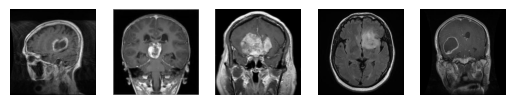

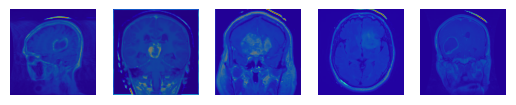

In [4]:
# Utiliser GradCAM pour visualiser les zones importantes pour les prédictions du modèle
# Charger un sous-ensemble de données d'image pour tester l'explication GradCAM

X = x_test[5:10]  
Y = y_test_cat[5:10]

# Créer un explainer GradCAM pour ton modèle
explainer = GradCAM(model) # boucler sur tout les diff explainer.

# Générer les explications pour les images sélectionnées
explanations = explainer.explain(X, Y)

# Afficher les explications superposées sur les images d'origine
for i in range(len(X)):
    plt.subplot(1, len(X), i + 1)
    plt.imshow(X[i],cmap='gray')  # Afficher l'image d'origine
 #   plt.imshow(explanations[i], cmap="jet", alpha=0.5)  # Superposer l'attribution
    plt.axis('off')
plt.show()
for i in range(len(X)):
    plt.subplot(1, len(X), i + 1)
    plt.imshow(X[i])  # Afficher l'image d'origine
    plt.imshow(explanations[i], cmap="jet", alpha=0.5)  # Superposer l'attribution
    plt.axis('off')
plt.show()


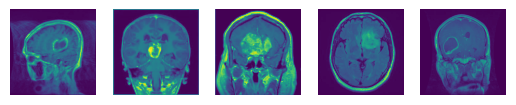

Method: IntegratedGradients


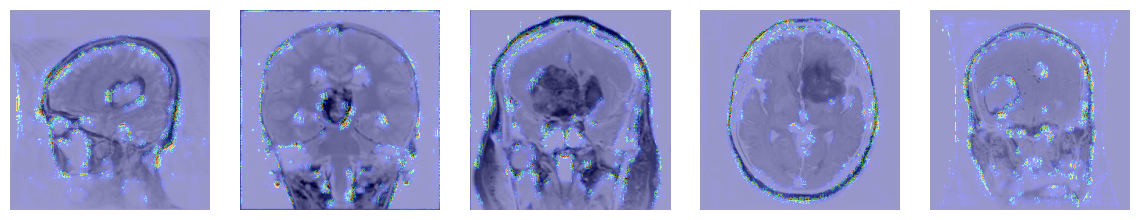



Method: GradCAM


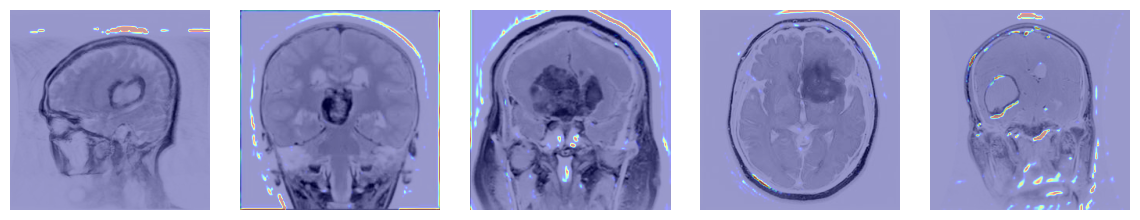

KeyboardInterrupt: 

In [ ]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP, Lime, KernelShap, SobolAttributionMethod)
import tensorflow as tf
import xplique
from xplique.plots import plot_attributions
# explaining the logits is to explain the class,
# explaining the softmax is to explain why this class is more likely
# it is therefore recommended to explain the logit
model.layers[-1].activation = tf.keras.activations.linear
batch_size = 64
X = x_test[5:10]  
Y = y_test_cat[5:10]
explainers = [
#             Saliency(model),
#             GradientInput(model),
#             GuidedBackprop(model),
             IntegratedGradients(model, steps=80, batch_size=batch_size),
 #            SmoothGrad(model, nb_samples=80, batch_size=batch_size),
 #            SquareGrad(model, nb_samples=80, batch_size=batch_size),
#             VarGrad(model, nb_samples=80, batch_size=batch_size),
             GradCAM(model),
#             Occlusion(model, patch_size=10, patch_stride=5, batch_size=batch_size),
#             Rise(model, nb_samples=4000, batch_size=batch_size),
#             SobolAttributionMethod(model, batch_size=batch_size)
             # Lime(model, nb_samples = 1000),
             # KernelShap(model, nb_samples = 1000)
]
for i in range(len(X)):
    plt.subplot(1, len(X), i + 1)
    plt.imshow(X[i])  # Afficher l'image d'origine
 #   plt.imshow(explanations[i], cmap="jet", alpha=0.5)  # Superposer l'attribution
    plt.axis('off')
plt.show()
for explainer in explainers:

  explanations = explainer(X, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")

In [1]:
# la taille des images de base sont 32*32, donc c pas ouf
#nos données devrait bien marcher dessus a voir